In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from surprise import Reader, Dataset, SVD, accuracy
from sklearn.model_selection import train_test_split

# Load the dataset
data = pd.read_csv('dq_ps_challenge_v2 1.csv')

# Display the first few rows
print(data.head())

# Get basic statistics
print(data.describe())

   idcol interaction   int_date  item     page        tod item_type  \
0    755     DISPLAY  17JAN2023  NONE  Screen1  Afternoon       ALL   
1   4521     DISPLAY  27FEB2023  NONE  Screen1  Afternoon       ALL   
2   4521     DISPLAY  18FEB2023  NONE  Screen1  Afternoon       ALL   
3   4521     DISPLAY  30JAN2023  NONE  Screen1    Morning       ALL   
4   4521       CLICK  05FEB2023  IBAB  Screen1  Afternoon    INSURE   

      item_descrip   segment beh_segment   active_ind  
0              NaN  segment3         B01  Semi Active  
1              NaN  segment1         B07  Semi Active  
2              NaN  segment1         B07  Semi Active  
3              NaN  segment1         B07  Semi Active  
4  GENERIC MESSAGE  segment1         B07  Semi Active  
              idcol
count  4.000000e+05
mean   3.395855e+09
std    8.169713e+09
min    7.550000e+02
25%    4.470050e+07
50%    1.145902e+08
75%    3.215196e+08
max    2.572863e+10


In [2]:
# Handle missing values
data = data.fillna('Unknown')

In [3]:
# Interaction Count per User
interaction_counts = data.groupby('idcol')['interaction'].count().reset_index()
interaction_counts.columns = ['idcol', 'total_interactions']
data = pd.merge(data, interaction_counts, on='idcol')

In [4]:
# Unique Items per User
unique_items = data.groupby('idcol')['item'].nunique().reset_index()
unique_items.columns = ['idcol', 'unique_items']
data = pd.merge(data, unique_items, on='idcol')

In [5]:
# Interaction Types per User
interaction_types = data.pivot_table(index='idcol', columns='interaction', aggfunc='size', fill_value=0).reset_index()
interaction_types.columns = ['idcol', 'num_display', 'num_click', 'num_checkout']
data = pd.merge(data, interaction_types, on='idcol')

In [6]:
# Interaction Time of Day
time_of_day_dummies = pd.get_dummies(data['tod'], prefix='tod')
data = pd.concat([data, time_of_day_dummies], axis=1)

In [7]:
# User Segment Encoding
segment_dummies = pd.get_dummies(data['segment'], prefix='segment')
data = pd.concat([data, segment_dummies], axis=1)

# Behavioral Segment Encoding
beh_segment_dummies = pd.get_dummies(data['beh_segment'], prefix='beh_segment')
data = pd.concat([data, beh_segment_dummies], axis=1)

In [8]:
# Active Indicator Encoding
active_ind_dummies = pd.get_dummies(data['active_ind'], prefix='active_ind')
data = pd.concat([data, active_ind_dummies], axis=1)

In [9]:
# Interaction Date Features
date_format = '%d%b%Y'
data['interaction_date'] = pd.to_datetime(data['int_date'], format=date_format)
data['day_of_week'] = data['interaction_date'].dt.dayofweek
data['month'] = data['interaction_date'].dt.month

In [10]:
# Convert Interaction to Numerical Values
interaction_mapping = {
    'DISPLAY': 1,
    'CLICK': 2,
    'CHECKOUT': 3
}
data['interaction_num'] = data['interaction'].map(interaction_mapping)

Columns available in correlation_data:
 Index(['interaction_num', 'day_of_week', 'month', 'tod_Afternoon', 'tod_Early',
       'tod_Evening', 'tod_Morning', 'page_Screen1', 'page_Screen2',
       'item_type_ALL', 'item_type_CONNECT', 'item_type_INSURE',
       'item_type_INVEST', 'item_type_LEND', 'item_type_LIFESTYLE',
       'item_type_TRANSACT', 'segment_segment1', 'segment_segment2',
       'segment_segment3', 'segment_segment4', 'beh_segment_B01',
       'beh_segment_B02', 'beh_segment_B03', 'beh_segment_B04',
       'beh_segment_B05', 'beh_segment_B06', 'beh_segment_B07',
       'beh_segment_B08', 'beh_segment_B09', 'beh_segment_B10',
       'beh_segment_B11', 'beh_segment_B12', 'beh_segment_B13',
       'beh_segment_B14', 'beh_segment_B15', 'beh_segment_B16',
       'beh_segment_B17', 'beh_segment_B18', 'beh_segment_B19',
       'beh_segment_B20', 'beh_segment_B21', 'beh_segment_B22',
       'beh_segment_B23', 'beh_segment_B24', 'beh_segment_B25',
       'beh_segment_B26', 'beh_

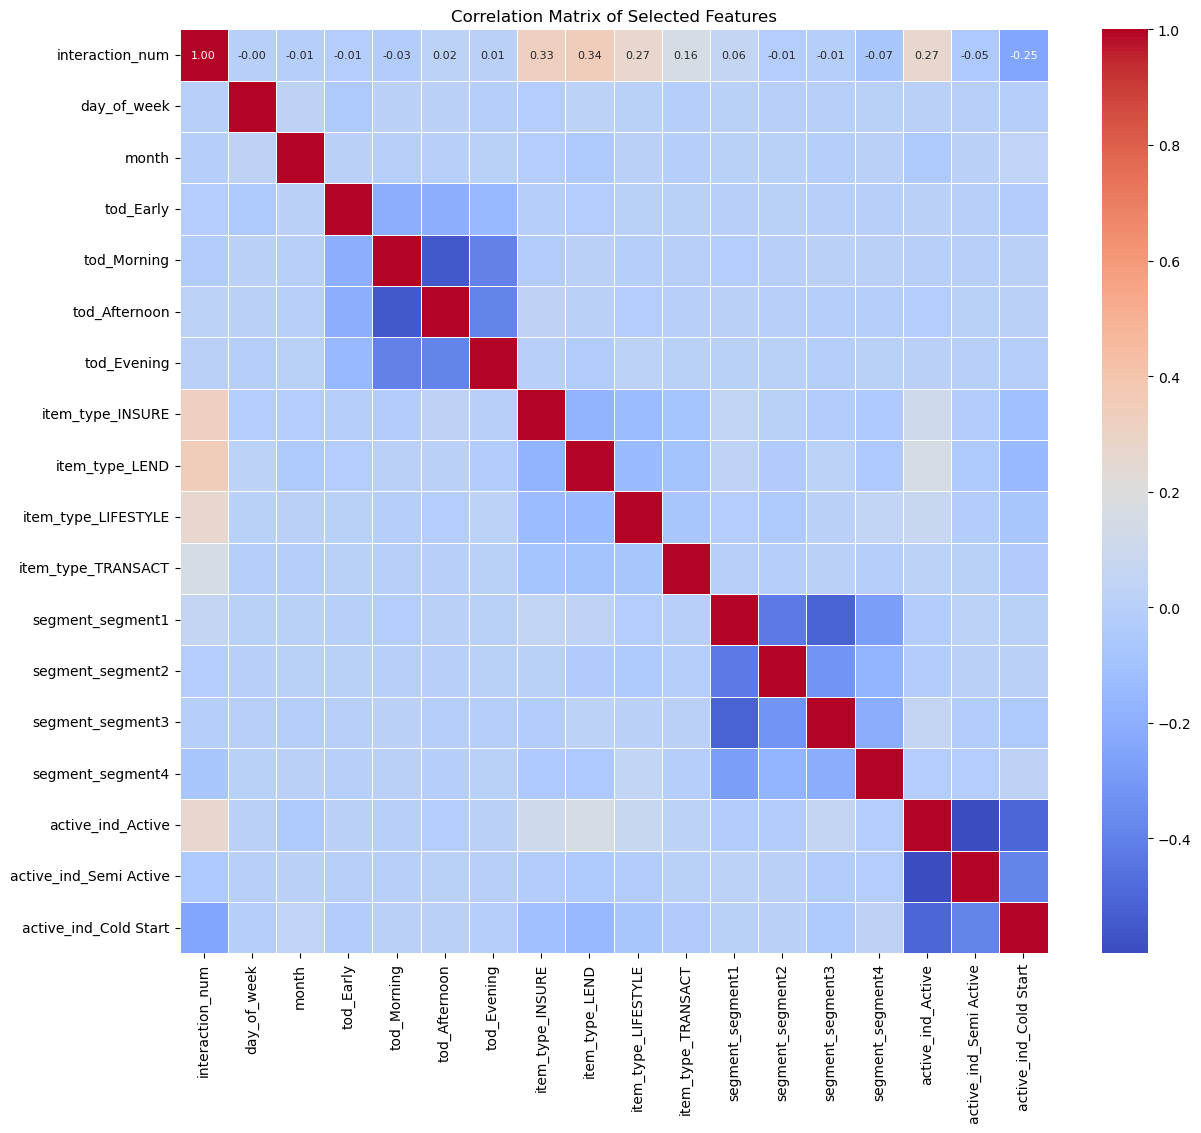

In [20]:
# One-hot encode categorical features
tod_dummies = pd.get_dummies(data['tod'], prefix='tod')
page_dummies = pd.get_dummies(data['page'], prefix='page')
item_type_dummies = pd.get_dummies(data['item_type'], prefix='item_type')
segment_dummies = pd.get_dummies(data['segment'], prefix='segment')
beh_segment_dummies = pd.get_dummies(data['beh_segment'], prefix='beh_segment')
active_ind_dummies = pd.get_dummies(data['active_ind'], prefix='active_ind')

# Combine all features into a single dataframe
correlation_data = pd.concat([
    data[['interaction_num', 'day_of_week', 'month']],
    tod_dummies,
    page_dummies,
    item_type_dummies,
    segment_dummies,
    beh_segment_dummies,
    active_ind_dummies
], axis=1)

# Print the columns of correlation_data
print("Columns available in correlation_data:\n", correlation_data.columns)

# Select a subset of the most relevant features for better readability
selected_features = [
    'interaction_num', 'day_of_week', 'month',
    'tod_Early', 'tod_Morning', 'tod_Afternoon', 'tod_Evening',
    'page_Screen 1', 'page_Screen 2',
    'item_type_INSURE', 'item_type_LEND', 'item_type_LIFESTYLE', 'item_type_TRANSACT',
    'segment_segment1', 'segment_segment2', 'segment_segment3', 'segment_segment4',
    'active_ind_Active', 'active_ind_Semi Active', 'active_ind_Cold Start'
]

# Filter selected_features to include only those that are available in correlation_data
selected_features = [feature for feature in selected_features if feature in correlation_data.columns]

# Create a correlation matrix
correlation_matrix = correlation_data[selected_features].corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5, annot_kws={"size": 8})
plt.title('Correlation Matrix of Selected Features')
plt.show()

In [13]:
# Prepare the data for Surprise library
data_for_surprise = data[['idcol', 'item', 'interaction_num']]
data_for_surprise.columns = ['userID', 'itemID', 'rating']

In [14]:
from sklearn.model_selection import train_test_split

# Split the data
train_data, test_data = train_test_split(data_for_surprise, test_size=0.2, random_state=42)

In [15]:
from surprise import Reader, Dataset, SVD

# Prepare the data for Surprise library
reader = Reader(rating_scale=(1, 3))
train_dataset = Dataset.load_from_df(train_data, reader)

# Build the full training set
trainset = train_dataset.build_full_trainset()

# Train the SVD Model
svd = SVD()
svd.fit(trainset)

In [16]:
from surprise import accuracy

# Predict Ratings on the Test Set
testset = [tuple(row) for row in test_data.itertuples(index=False)]
predictions = svd.test(testset)

# Store actual and predicted ratings
y_test = [pred.r_ui for pred in predictions]
y_pred = [pred.est for pred in predictions]

# Calculate and Print Evaluation Metrics
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)
print(f'RMSE: {rmse}, MAE: {mae}')


RMSE: 0.3812
MAE:  0.2773
RMSE: 0.3812082727815086, MAE: 0.2772707198351553


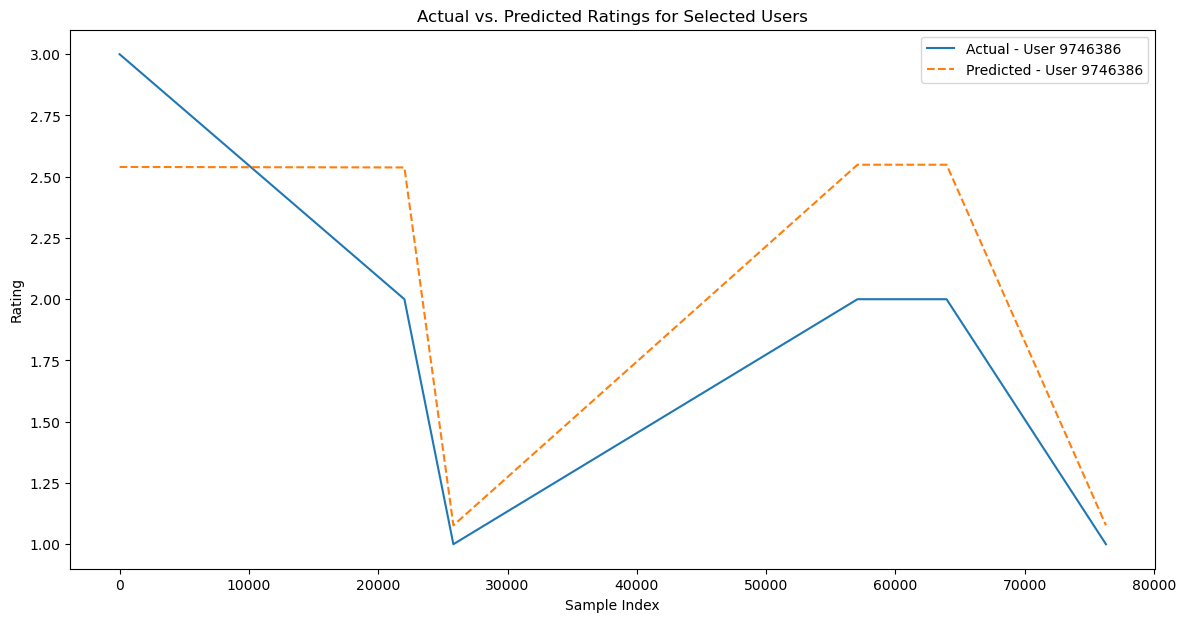

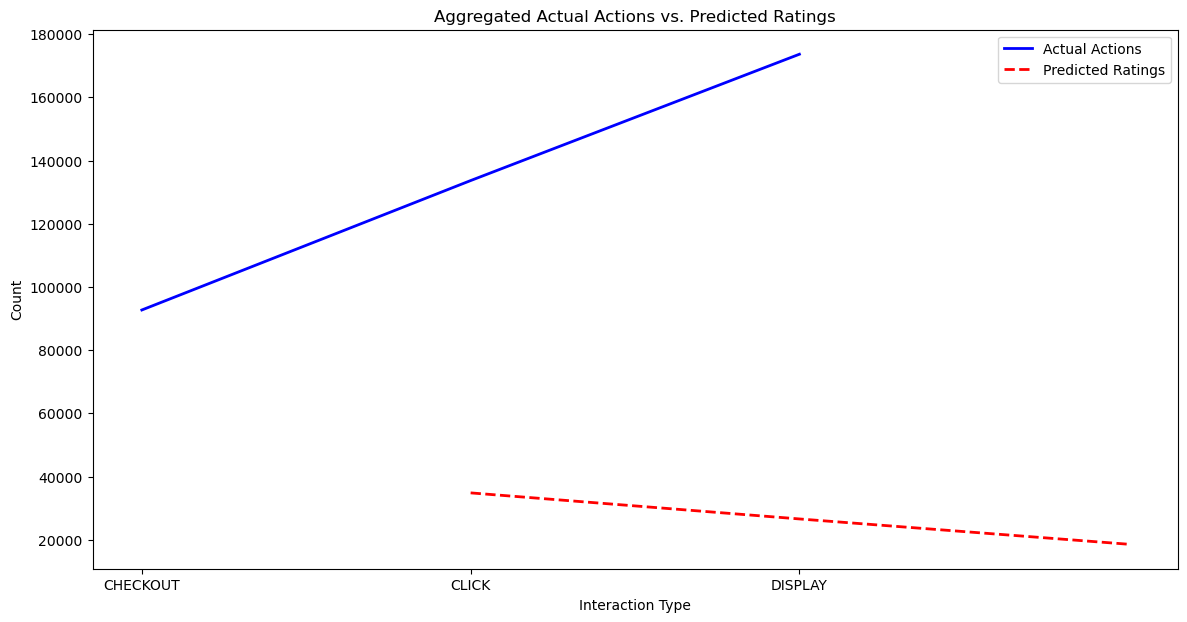

In [17]:

# Visualize Actual vs. Predicted Ratings using Line Graph for a Subset of Users
plt.figure(figsize=(14, 7))
selected_user_ids = set([pred.uid for pred in predictions[:1]])  # Selecting the first 1 unique users for simplicity

for user_id in selected_user_ids:
    user_indices = [i for i, pred in enumerate(predictions) if pred.uid == user_id]
    if user_indices:
        plt.plot(user_indices, [y_test[i] for i in user_indices], label=f'Actual - User {user_id}', linewidth=1.5)
        plt.plot(user_indices, [y_pred[i] for i in user_indices], linestyle='--', label=f'Predicted - User {user_id}', linewidth=1.5)

plt.title('Actual vs. Predicted Ratings for Selected Users')
plt.xlabel('Sample Index')
plt.ylabel('Rating')
plt.legend(loc='best', bbox_to_anchor=(1, 1))
plt.show()


# Aggregate Predictions and Actions
interaction_aggregated = data.groupby('interaction')['interaction_num'].count()
predicted_aggregated = pd.DataFrame(predictions).groupby('r_ui')['est'].count()

# Plot Aggregated Predictions vs. Actions
plt.figure(figsize=(14, 7))
plt.plot(interaction_aggregated.index, interaction_aggregated.values, color='blue', label='Actual Actions', linewidth=2)
plt.plot(predicted_aggregated.index, predicted_aggregated.values, color='red', linestyle='--', label='Predicted Ratings', linewidth=2)
plt.title('Aggregated Actual Actions vs. Predicted Ratings')
plt.xlabel('Interaction Type')
plt.ylabel('Count')
plt.legend()
plt.show()

In [18]:
def suggest_top_products(user_id, model, n=5):
    # Filter data for the given user
    user_data = data_for_surprise[data_for_surprise['userID'] == user_id]
    
    # Get items the user has already rated
    items_rated_by_user = user_data['itemID'].unique()
    
    # Get all items
    all_items = data_for_surprise['itemID'].unique()
    
    # Identify items the user has not rated
    items_to_predict = set(all_items) - set(items_rated_by_user)

    # Predict ratings for all unrated items
    predictions = [model.predict(user_id, item) for item in items_to_predict]
    
    # Sort predictions by estimated rating in descending order
    predictions.sort(key=lambda x: x.est, reverse=True)
    
    # Get top N predictions
    top_predictions = predictions[:n]
    
    # Return item IDs and predicted ratings
    return [(pred.iid, pred.est) for pred in top_predictions]

# Usage
user_id_example = 8469
top_products = suggest_top_products(user_id_example, svd)

# Print top product recommendations for the user
print(f"Top product recommendations for user {user_id_example}:")
for item_id, predicted_rating in top_products:
    print(f"Item ID: {item_id}, Predicted Rating: {predicted_rating}")


Top product recommendations for user 8469:
Item ID: EBGM, Predicted Rating: 2.5953287984524027
Item ID: CCAI, Predicted Rating: 2.5535198076929673
Item ID: IBDL, Predicted Rating: 2.5534266080911823
Item ID: IBDP, Predicted Rating: 2.535355475511385
Item ID: CCLI, Predicted Rating: 2.52636085970508


In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from surprise import Reader, Dataset, SVD, KNNBasic, accuracy
from sklearn.model_selection import train_test_split

# Load the dataset
data = pd.read_csv('dq_ps_challenge_v2 1.csv')

# Display the first few rows
print(data.head())

# Get basic statistics
print(data.describe())

# Handle missing values
data = data.fillna('Unknown')

# Interaction Count per User
interaction_counts = data.groupby('idcol')['interaction'].count().reset_index()
interaction_counts.columns = ['idcol', 'total_interactions']
data = pd.merge(data, interaction_counts, on='idcol')

# Unique Items per User
unique_items = data.groupby('idcol')['item'].nunique().reset_index()
unique_items.columns = ['idcol', 'unique_items']
data = pd.merge(data, unique_items, on='idcol')

# Interaction Types per User
interaction_types = data.pivot_table(index='idcol', columns='interaction', aggfunc='size', fill_value=0).reset_index()
interaction_types.columns = ['idcol', 'num_display', 'num_click', 'num_checkout']
data = pd.merge(data, interaction_types, on='idcol')

# Interaction Time of Day
time_of_day_dummies = pd.get_dummies(data['tod'], prefix='tod')
data = pd.concat([data, time_of_day_dummies], axis=1)

# User Segment Encoding
segment_dummies = pd.get_dummies(data['segment'], prefix='segment')
data = pd.concat([data, segment_dummies], axis=1)

# Behavioral Segment Encoding
beh_segment_dummies = pd.get_dummies(data['beh_segment'], prefix='beh_segment')
data = pd.concat([data, beh_segment_dummies], axis=1)

# Active Indicator Encoding
active_ind_dummies = pd.get_dummies(data['active_ind'], prefix='active_ind')
data = pd.concat([data, active_ind_dummies], axis=1)

# Interaction Date Features
date_format = '%d%b%Y'
data['interaction_date'] = pd.to_datetime(data['int_date'], format=date_format)
data['day_of_week'] = data['interaction_date'].dt.dayofweek
data['month'] = data['interaction_date'].dt.month

# Convert Interaction to Numerical Values
interaction_mapping = {
    'DISPLAY': 1,
    'CLICK': 2,
    'CHECKOUT': 3
}
data['interaction_num'] = data['interaction'].map(interaction_mapping)

# Prepare the data for Surprise library
data_for_surprise = data[['idcol', 'item', 'interaction_num']]
data_for_surprise.columns = ['userID', 'itemID', 'rating']


   idcol interaction   int_date  item     page        tod item_type  \
0    755     DISPLAY  17JAN2023  NONE  Screen1  Afternoon       ALL   
1   4521     DISPLAY  27FEB2023  NONE  Screen1  Afternoon       ALL   
2   4521     DISPLAY  18FEB2023  NONE  Screen1  Afternoon       ALL   
3   4521     DISPLAY  30JAN2023  NONE  Screen1    Morning       ALL   
4   4521       CLICK  05FEB2023  IBAB  Screen1  Afternoon    INSURE   

      item_descrip   segment beh_segment   active_ind  
0              NaN  segment3         B01  Semi Active  
1              NaN  segment1         B07  Semi Active  
2              NaN  segment1         B07  Semi Active  
3              NaN  segment1         B07  Semi Active  
4  GENERIC MESSAGE  segment1         B07  Semi Active  
              idcol
count  4.000000e+05
mean   3.395855e+09
std    8.169713e+09
min    7.550000e+02
25%    4.470050e+07
50%    1.145902e+08
75%    3.215196e+08
max    2.572863e+10


In [25]:
# Split the data
train_data, test_data = train_test_split(data_for_surprise, test_size=0.2, random_state=42)

reader = Reader(rating_scale=(1, 3))
train_dataset = Dataset.load_from_df(train_data, reader)

# Build the full training set
trainset = train_dataset.build_full_trainset()

# Train the SVD Model
svd = SVD()
svd.fit(trainset)


In [26]:
# Reduce the dataset size for KNN model
data_for_surprise_small = data_for_surprise.sample(n=10000, random_state=42)
train_data_small, test_data_small = train_test_split(data_for_surprise_small, test_size=0.2, random_state=42)
train_dataset_small = Dataset.load_from_df(train_data_small, reader)

# Build the full training set
trainset_small = train_dataset_small.build_full_trainset()

# Train the KNNBasic Model on the smaller dataset
knn = KNNBasic()
knn.fit(trainset_small)


Computing the msd similarity matrix...
Done computing similarity matrix.


In [27]:
# Predict Ratings on the Test Set
testset = [tuple(row) for row in test_data.itertuples(index=False)]
testset_small = [tuple(row) for row in test_data_small.itertuples(index=False)]
predictions_svd = svd.test(testset)
predictions_knn = knn.test(testset_small)

# Store actual and predicted ratings
y_test = [pred.r_ui for pred in predictions_svd]
y_pred_svd = [pred.est for pred in predictions_svd]
y_pred_knn = [pred.est for pred in predictions_knn]

# Calculate and Print Evaluation Metrics for SVD
rmse_svd = accuracy.rmse(predictions_svd)
mae_svd = accuracy.mae(predictions_svd)
print(f'SVD - RMSE: {rmse_svd}, MAE: {mae_svd}')

# Calculate and Print Evaluation Metrics for KNNBasic
rmse_knn = accuracy.rmse(predictions_knn)
mae_knn = accuracy.mae(predictions_knn)
print(f'KNNBasic - RMSE: {rmse_knn}, MAE: {mae_knn}')


RMSE: 0.3811
MAE:  0.2773
SVD - RMSE: 0.3810743885310097, MAE: 0.2772653355160672
RMSE: 0.7810
MAE:  0.6736
KNNBasic - RMSE: 0.7810119311360062, MAE: 0.6735884997996113


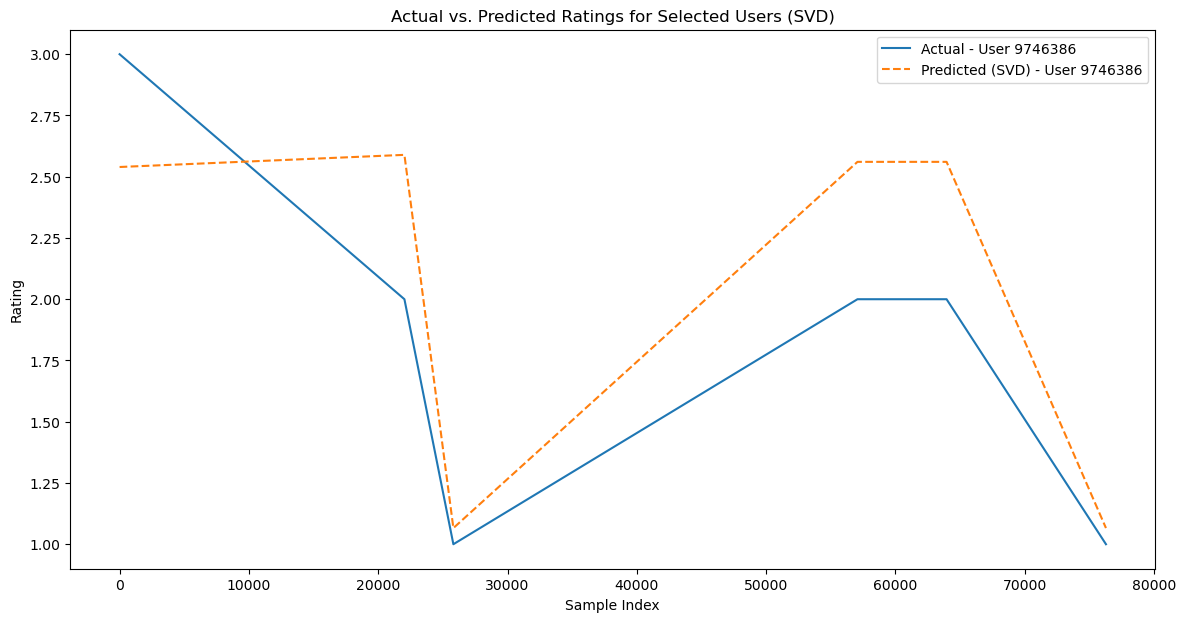

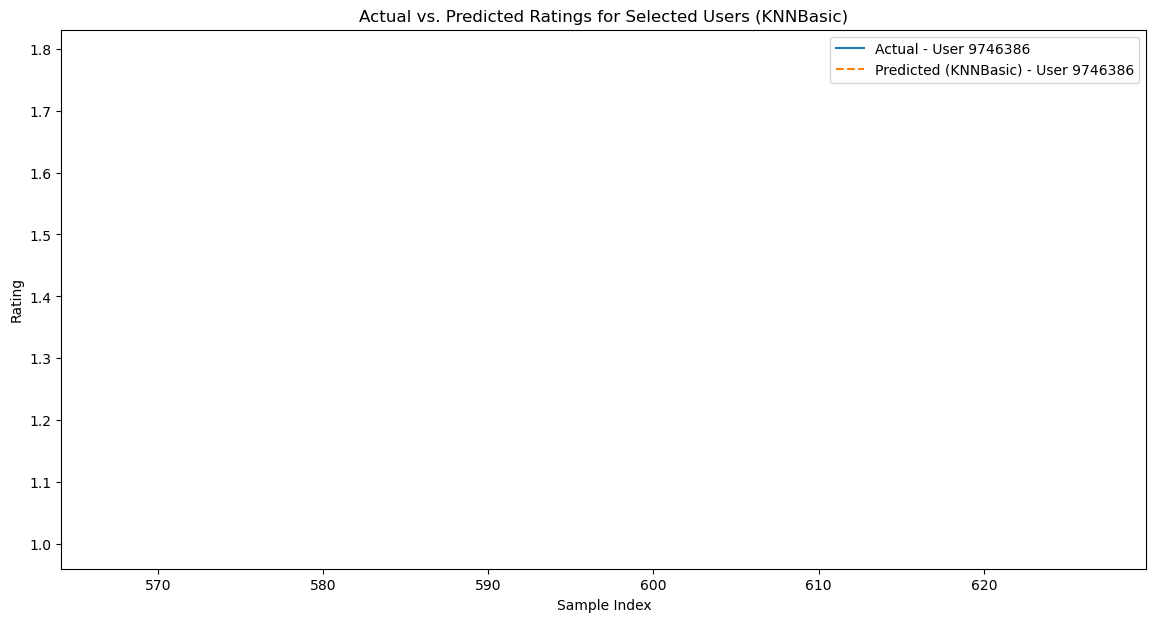

In [37]:
# Visualize Actual vs. Predicted Ratings using Line Graph for a Subset of Users for SVD
plt.figure(figsize=(14, 7))
selected_user_ids = set([pred.uid for pred in predictions_svd[:1]])  # Selecting the first 1 unique users for simplicity

for user_id in selected_user_ids:
    user_indices_svd = [i for i, pred in enumerate(predictions_svd) if pred.uid == user_id]
    if user_indices_svd:
        plt.plot(user_indices_svd, [y_test[i] for i in user_indices_svd], label=f'Actual - User {user_id}', linewidth=1.5)
        plt.plot(user_indices_svd, [y_pred_svd[i] for i in user_indices_svd], linestyle='--', label=f'Predicted (SVD) - User {user_id}', linewidth=1.5)

plt.title('Actual vs. Predicted Ratings for Selected Users (SVD)')
plt.xlabel('Sample Index')
plt.ylabel('Rating')
plt.legend(loc='best', bbox_to_anchor=(1, 1))
plt.show()

# Visualize Actual vs. Predicted Ratings using Line Graph for a Subset of Users for KNNBasic
plt.figure(figsize=(14, 7))
selected_user_ids = set([pred.uid for pred in predictions_svd[:1]])  # Selecting the first 1 unique users for simplicity
for user_id in selected_user_ids:
    user_indices_knn = [i for i, pred in enumerate(predictions_knn) if pred.uid == user_id]
    if user_indices_knn:
        plt.plot(user_indices_knn, [y_test[i] for i in user_indices_knn], label=f'Actual - User {user_id}', linewidth=1.5)
        plt.plot(user_indices_knn, [y_pred_knn[i] for i in user_indices_knn], linestyle='--', label=f'Predicted (KNNBasic) - User {user_id}', linewidth=1.5)

plt.title('Actual vs. Predicted Ratings for Selected Users (KNNBasic)')
plt.xlabel('Sample Index')
plt.ylabel('Rating')
plt.legend(loc='best', bbox_to_anchor=(1, 1))
plt.show()


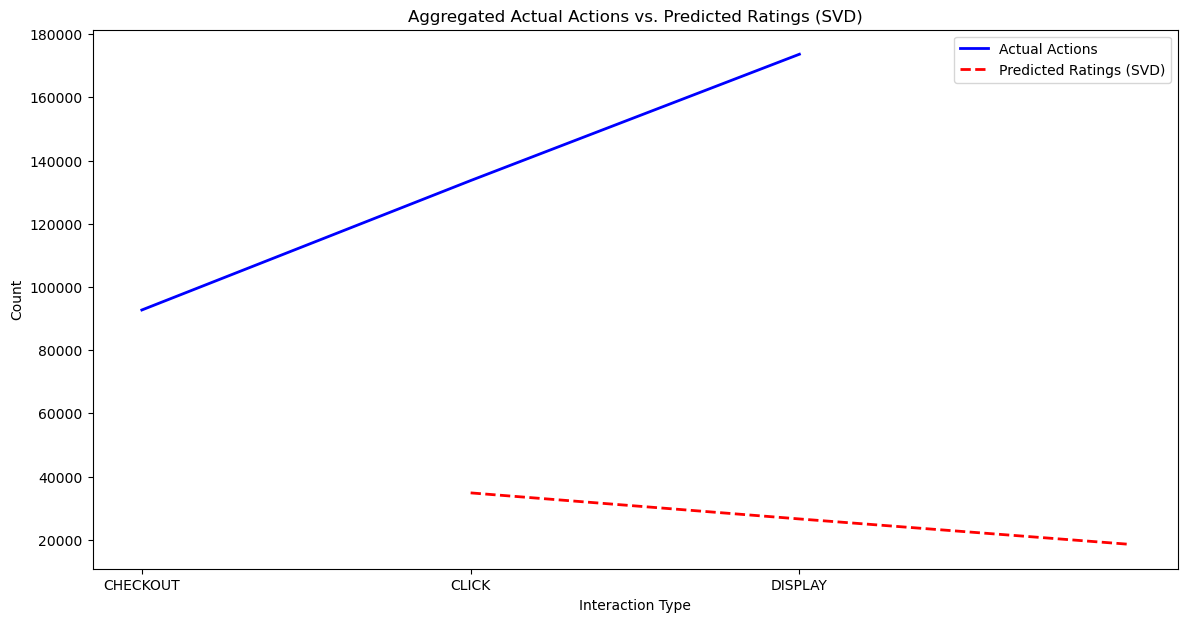

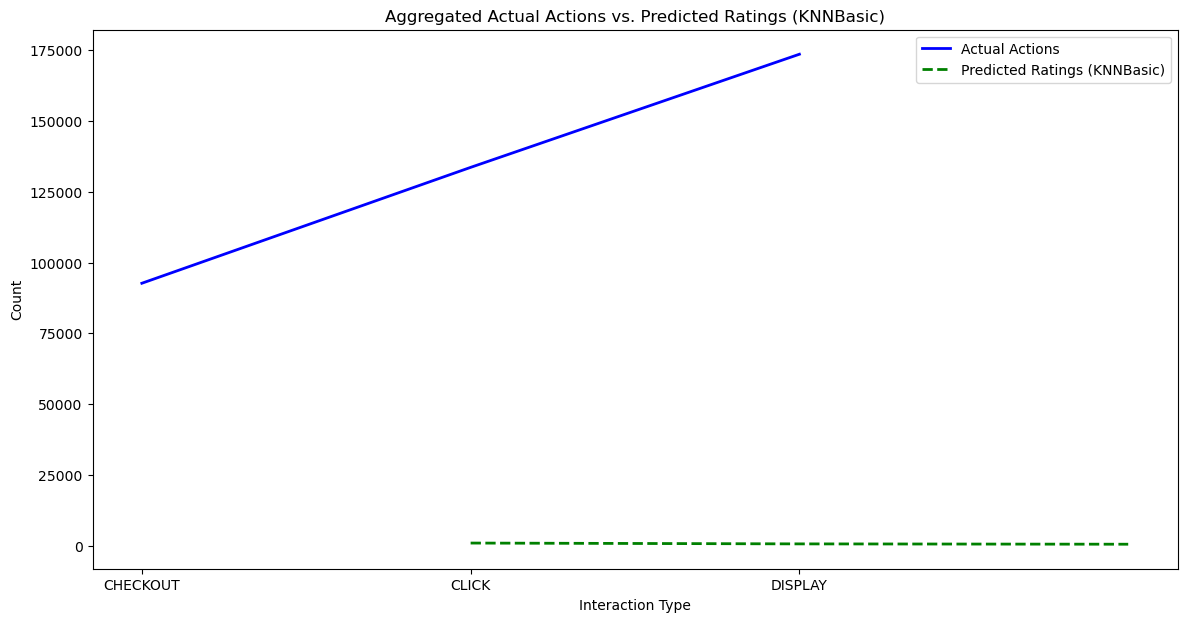

SVD - RMSE: 0.3810743885310097, MAE: 0.2772653355160672
KNNBasic - RMSE: 0.7810119311360062, MAE: 0.6735884997996113
SVD model performs better based on RMSE.
SVD model performs better based on MAE.


In [38]:
# Compare Aggregated Predictions and Actions for Both Models
interaction_aggregated = data.groupby('interaction')['interaction_num'].count()
predicted_aggregated_svd = pd.DataFrame(predictions_svd).groupby('r_ui')['est'].count()
predicted_aggregated_knn = pd.DataFrame(predictions_knn).groupby('r_ui')['est'].count()

# Plot Aggregated Predictions vs. Actions for SVD
plt.figure(figsize=(14, 7))
plt.plot(interaction_aggregated.index, interaction_aggregated.values, color='blue', label='Actual Actions', linewidth=2)
plt.plot(predicted_aggregated_svd.index, predicted_aggregated_svd.values, color='red', linestyle='--', label='Predicted Ratings (SVD)', linewidth=2)
plt.title('Aggregated Actual Actions vs. Predicted Ratings (SVD)')
plt.xlabel('Interaction Type')
plt.ylabel('Count')
plt.legend()
plt.show()

# Plot Aggregated Predictions vs. Actions for KNNBasic
plt.figure(figsize=(14, 7))
plt.plot(interaction_aggregated.index, interaction_aggregated.values, color='blue', label='Actual Actions', linewidth=2)
plt.plot(predicted_aggregated_knn.index, predicted_aggregated_knn.values, color='green', linestyle='--', label='Predicted Ratings (KNNBasic)', linewidth=2)
plt.title('Aggregated Actual Actions vs. Predicted Ratings (KNNBasic)')
plt.xlabel('Interaction Type')
plt.ylabel('Count')
plt.legend()
plt.show()

# Function to Compare Models
def compare_models(predictions_svd, predictions_knn):
    # Calculate RMSE and MAE for both models
    rmse_svd = accuracy.rmse(predictions_svd, verbose=False)
    mae_svd = accuracy.mae(predictions_svd, verbose=False)
    rmse_knn = accuracy.rmse(predictions_knn, verbose=False)
    mae_knn = accuracy.mae(predictions_knn, verbose=False)
    
    # Print the results
    print(f'SVD - RMSE: {rmse_svd}, MAE: {mae_svd}')
    print(f'KNNBasic - RMSE: {rmse_knn}, MAE: {mae_knn}')
    
    # Determine the better model
    if rmse_svd < rmse_knn:
        print('SVD model performs better based on RMSE.')
    else:
        print('KNNBasic model performs better based on RMSE.')
        
    if mae_svd < mae_knn:
        print('SVD model performs better based on MAE.')
    else:
        print('KNNBasic model performs better based on MAE.')

# Compare the models
compare_models(predictions_svd, predictions_knn)

    


In [39]:
# Function to Suggest Top Products
def suggest_top_products(user_id, model, n=5):
    # Filter data for the given user
    user_data = data_for_surprise[data_for_surprise['userID'] == user_id]
    
    # Get items the user has already rated
    items_rated_by_user = user_data['itemID'].unique()
    
    # Get all items
    all_items = data_for_surprise['itemID'].unique()
    
    # Identify items the user has not rated
    items_to_predict = set(all_items) - set(items_rated_by_user)

    # Predict ratings for all unrated items
    predictions = [model.predict(user_id, item) for item in items_to_predict]
    
    # Sort predictions by estimated rating in descending order
    predictions.sort(key=lambda x: x.est, reverse=True)
    
    # Get top N predictions
    top_predictions = predictions[:n]
    
    # Return item IDs and predicted ratings
    return [(pred.iid, pred.est) for pred in top_predictions]

# Usage for SVD
user_id_example = 8469
top_products_svd = suggest_top_products(user_id_example, svd)

# Print top product recommendations for the user using SVD
print(f"Top product recommendations for user {user_id_example} using SVD:")
for item_id, predicted_rating in top_products_svd:
    print(f"Item ID: {item_id}, Predicted Rating: {predicted_rating}")

# Usage for KNNBasic
top_products_knn = suggest_top_products(user_id_example, knn)

# Print top product recommendations for the user using KNNBasic
print(f"Top product recommendations for user {user_id_example} using KNNBasic:")
for item_id, predicted_rating in top_products_knn:
    print(f"Item ID: {item_id}, Predicted Rating: {predicted_rating}")


Top product recommendations for user 8469 using SVD:
Item ID: CCAI, Predicted Rating: 2.5693035915198865
Item ID: EBSB, Predicted Rating: 2.5574765694111443
Item ID: KYCA, Predicted Rating: 2.548452373573931
Item ID: IPRA, Predicted Rating: 2.545011635107511
Item ID: HLGH, Predicted Rating: 2.543451003717914
Top product recommendations for user 8469 using KNNBasic:
Item ID: MMMC, Predicted Rating: 1.791
Item ID: CBCC, Predicted Rating: 1.791
Item ID: EVAP, Predicted Rating: 1.791
Item ID: CCCS, Predicted Rating: 1.791
Item ID: CANL, Predicted Rating: 1.791
